In [1]:
import os
import numpy as np
import pandas as pd
from scipy import optimize
from scipy import linalg
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import array as arr
import seaborn as sns
import random
import pylab
from scipy import stats
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import inverse_method_funs as inv


In [2]:
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

## Upload required values

In [6]:
fname_EV = 'D:/GLIDER2018/Echosounder/EVexport/Wideband_frequency_response_28AM.csv'
#fname_EV = 'D:/GLIDER2018/Echosounder/EVexport/Wideband_frequency_response_25AM_surface.csv'
#fname_EV = 'D:/GLIDER2018/Echosounder/EVexport/Wideband_frequency_response_noise.csv'
freqs_EV, sv = inv.read_widebandfrequencyresponse(fname_EV, extracols = 2)

In [7]:
fname_sim = '../ZooScatStuff/my_data.feather'
specs, freqs_sim, sig_bs_sim, sig_bs_mean = inv.read_scatteringmodelsimulations(fname_sim, nsim=1000)

Resample the simulation values to match the frequencies of the measured frequencies

In [8]:
sigma_bs = np.zeros([len(freqs_EV),np.shape(sig_bs_sim)[1],len(specs)])
sigma_bs_mean = np.zeros([len(freqs_EV),len(specs)])

for ind_spec in range(0,len(specs)):
    f = UnivariateSpline(freqs_sim,sig_bs_mean[:,ind_spec], k=5)
    sigma_bs_mean[:,ind_spec] = f(freqs_EV)
    for ind_sim in range(0,np.shape(sig_bs_sim)[1]):
        f = UnivariateSpline(freqs_sim,sig_bs_sim[:,ind_sim,ind_spec], k=5)
        sigma_bs[:,ind_sim,ind_spec] = f(freqs_EV)

## Plot imported values (sv and crossectional backscatter)

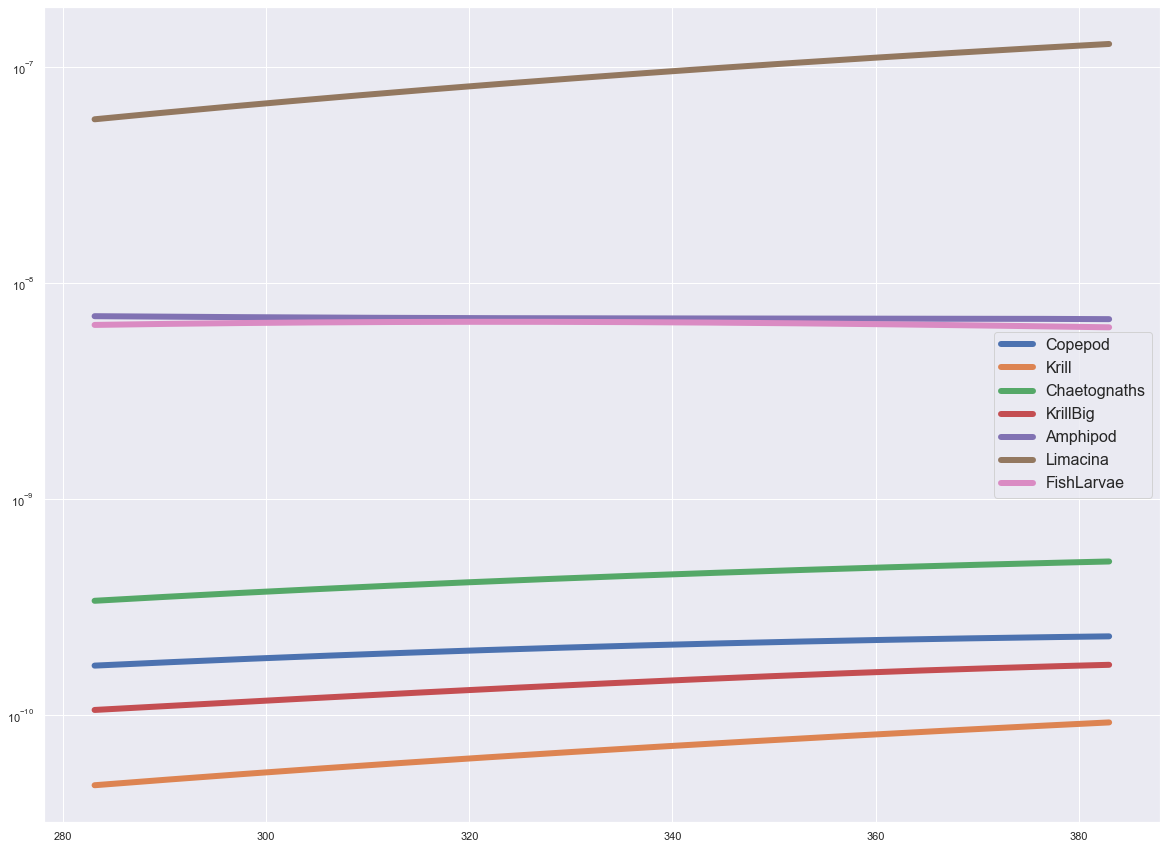

In [9]:
fig=plt.figure(figsize=(20, 15),facecolor='w', edgecolor='k')
plt.semilogy(freqs_EV,sigma_bs_mean, linewidth=6)
plt.legend(specs, fontsize=16)

# Try different Least-Squares calculators
scipy - optimize - lsq_linear
For least-squares problems with bounds on the variables. I include bound of [0, inf) ; positive values

Start with default method: ‘trf’ : Trust Region Reflective algorithm adapted for a linear least-squares problem. This is an interior-point-like method and the required number of iterations is weakly correlated with the number of variables. **These results look like a really good start to me**

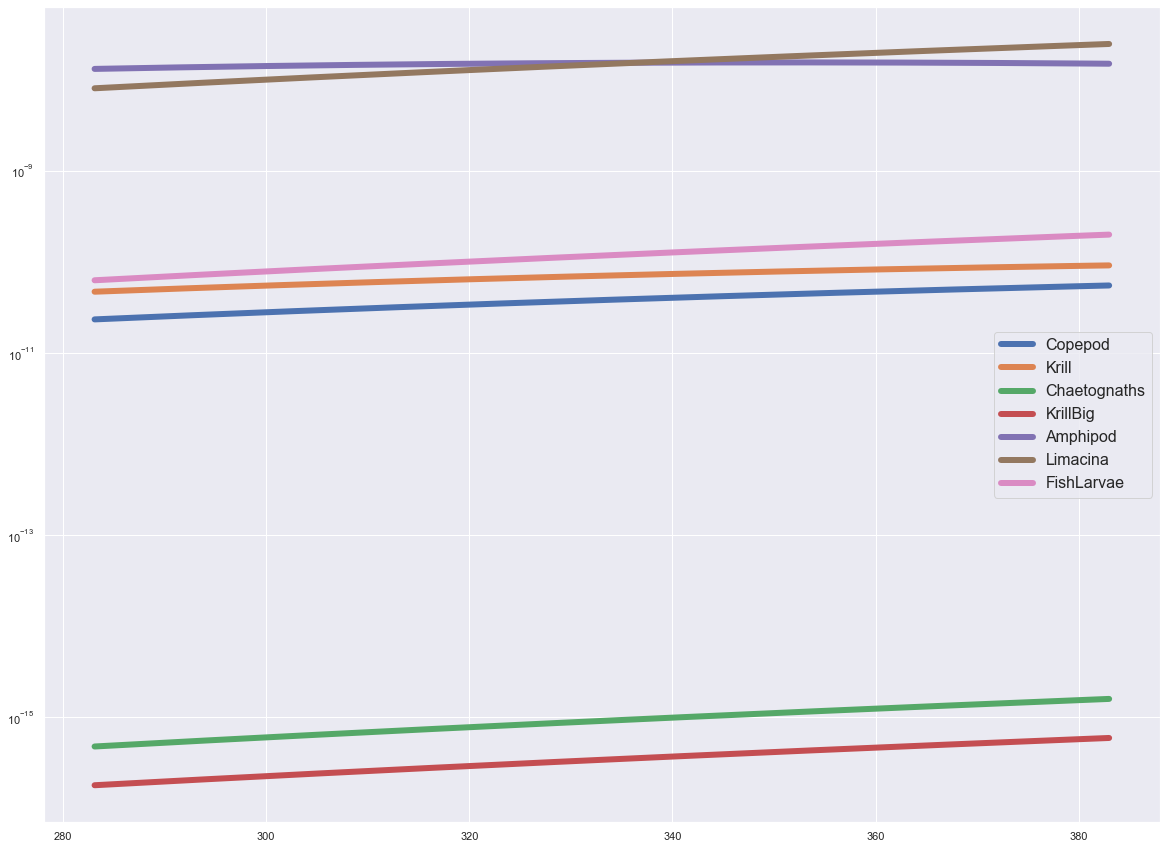

In [10]:
# Which cross-sectional backscatter simulation to choose... The mean is boring and shows no variability. 
#Should be mean "shape" more in bootstrapleast-squares.ipynb
sigbs = sigma_bs_mean
sigbs = sigma_bs[:,300,:]
fig=plt.figure(figsize=(20, 15),facecolor='w', edgecolor='k')
plt.semilogy(freqs_EV,sigbs, linewidth=6)
plt.legend(specs, fontsize=16)

In [11]:
density = np.zeros([np.shape(sigma_bs_mean)[1], np.shape(sv)[1]])

for ind in range(0, np.shape(sv)[1]):
    d = optimize.lsq_linear(sigbs, arr.array('d',sv[:,ind]), bounds=(0,np.inf))
    density[:,ind] = d.x

Text(0.5, 0, 'Functional group')

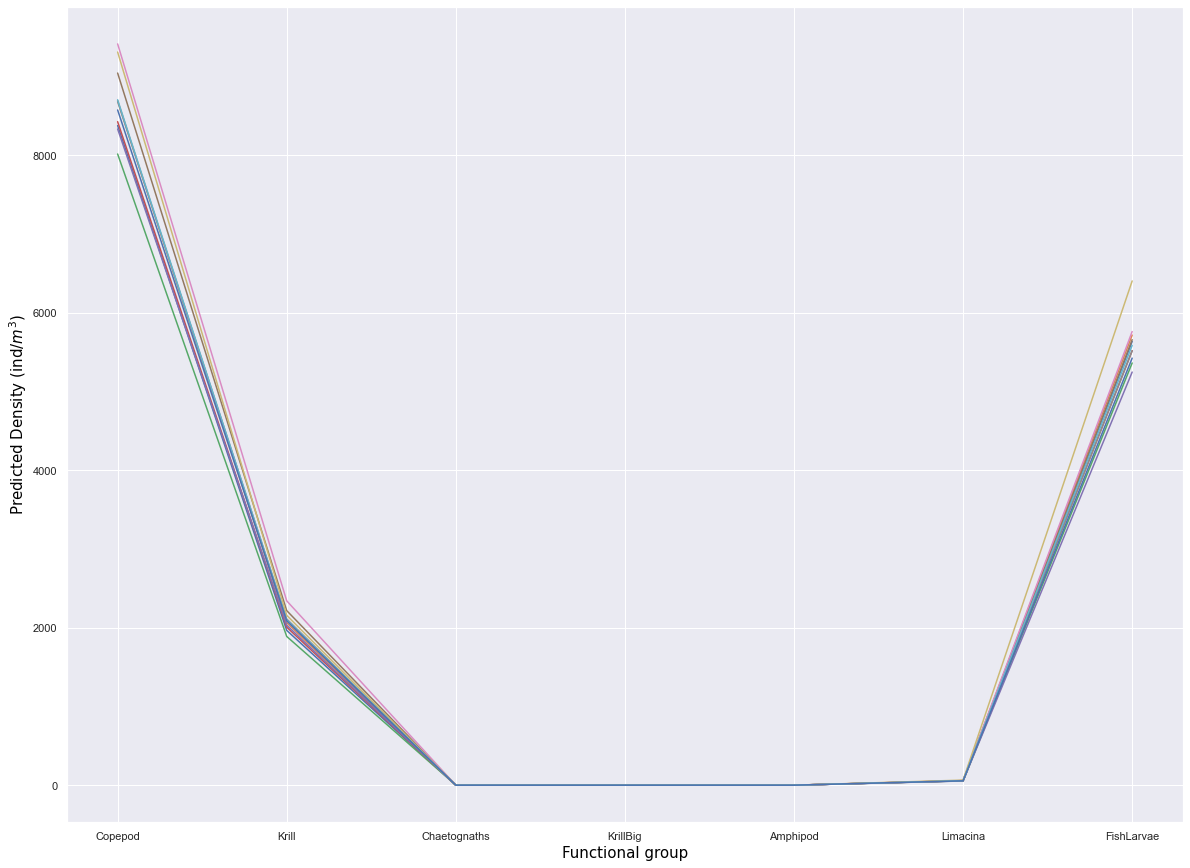

In [12]:
fig=plt.figure(figsize=(20, 15),facecolor='w', edgecolor='k')
plt.plot(specs,(density[:]))
plt.ylabel('Predicted Density (ind/$m^3$)', axis_font)
plt.xlabel('Functional group', axis_font)

### Compare the predicted sv with the measured sv

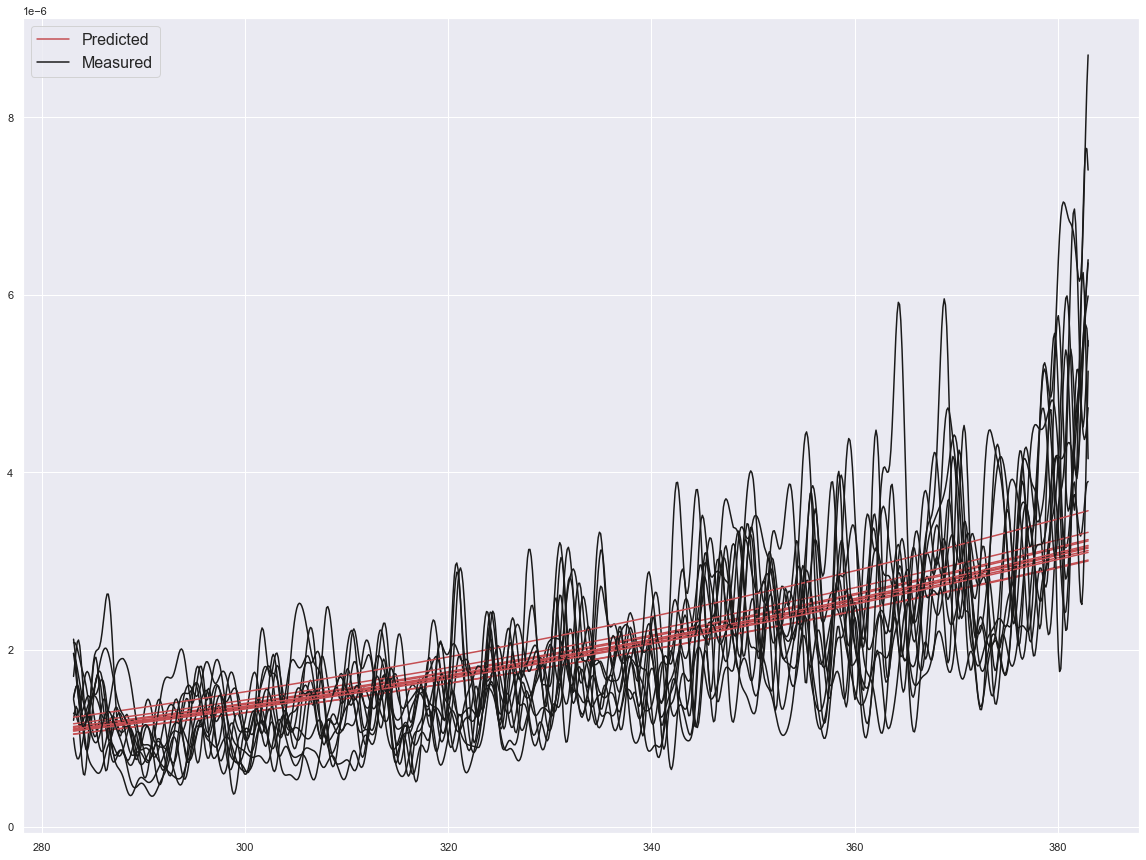

In [13]:
fig=plt.figure(figsize=(20, 15))
for ind in range(0, np.shape(sv)[1]):
    plt.plot(freqs,np.sum(sigbs*density[:,ind],1),'r', freqs ,arr.array('d',sv[:,ind]),'k')
plt.legend(['Predicted', 'Measured'], fontsize=16)

Also try with ‘bvls’ : Bounded-variable least-squares algorithm. This is an active set method, which requires the number of iterations comparable to the number of variables. Can’t be used when A is sparse or LinearOperator.
**not good results**

### try steepest descent? As used by...

In [14]:
#abundance from MultinetDataSP2018_ST7-18_Flaket.xlsx
density_init=[100, 20, 7, 10, 4, 30, 5]

In [18]:
density_SGD = np.zeros([np.shape(sigma_bs_mean)[1], np.shape(sv)[1]])
density_intercept = np.zeros([np.shape(sv)[1]])
for ind in range(0, np.shape(sv)[1]):
     # Always scale the input. The most convenient way is to use a pipeline.
    reg = linear_model.SGDRegressor(warm_start=True,n_iter_no_change=10)
    reg.fit(sigbs, arr.array('d',sv[:,ind]))#,coef_init=density_init) # Can apply weights
    density_SGD[:,ind] = reg.coef_
    density_intercept[ind] = reg.intercept_

Text(0.5, 0, 'Functional group')

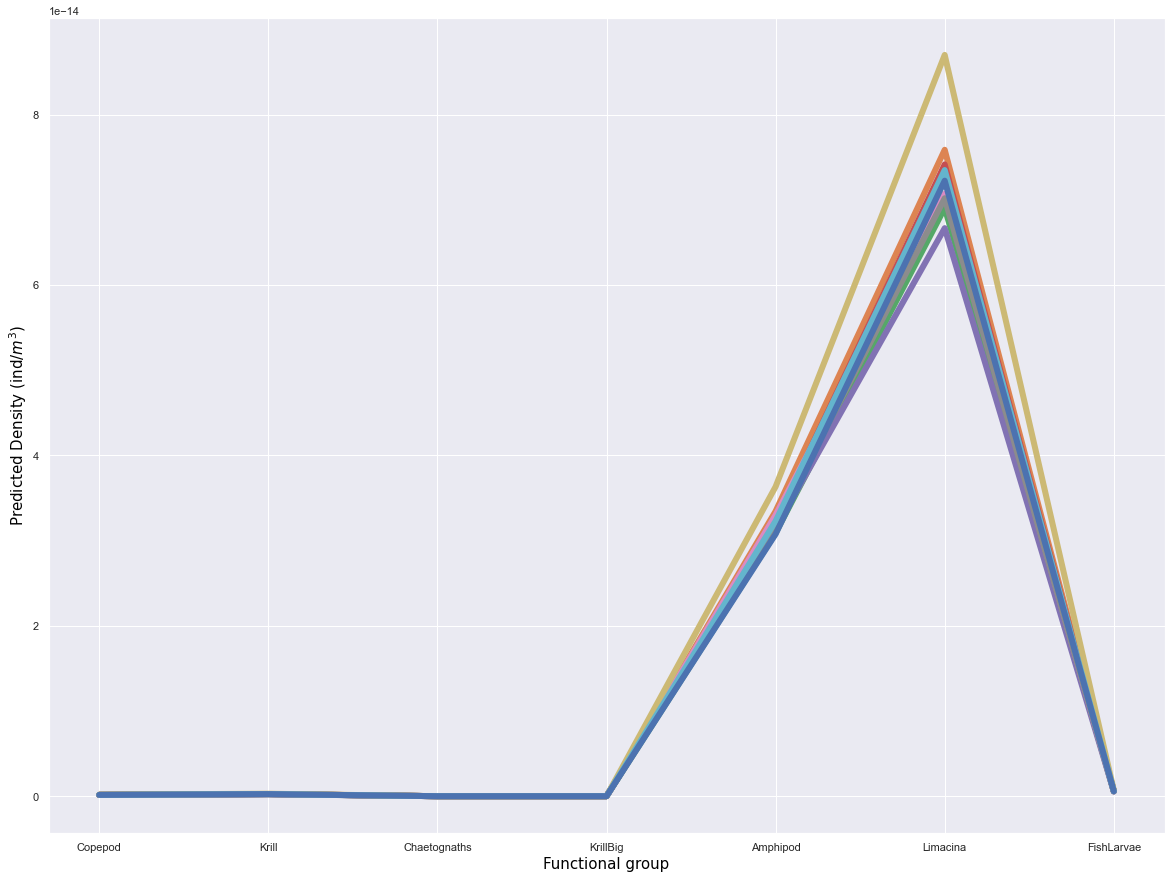

In [16]:
fig=plt.figure(figsize=(20, 15),facecolor='w', edgecolor='k')
plt.plot(specs, density_SGD, linewidth=6)
plt.ylabel('Predicted Density (ind/$m^3$)', axis_font)
plt.xlabel('Functional group', axis_font)

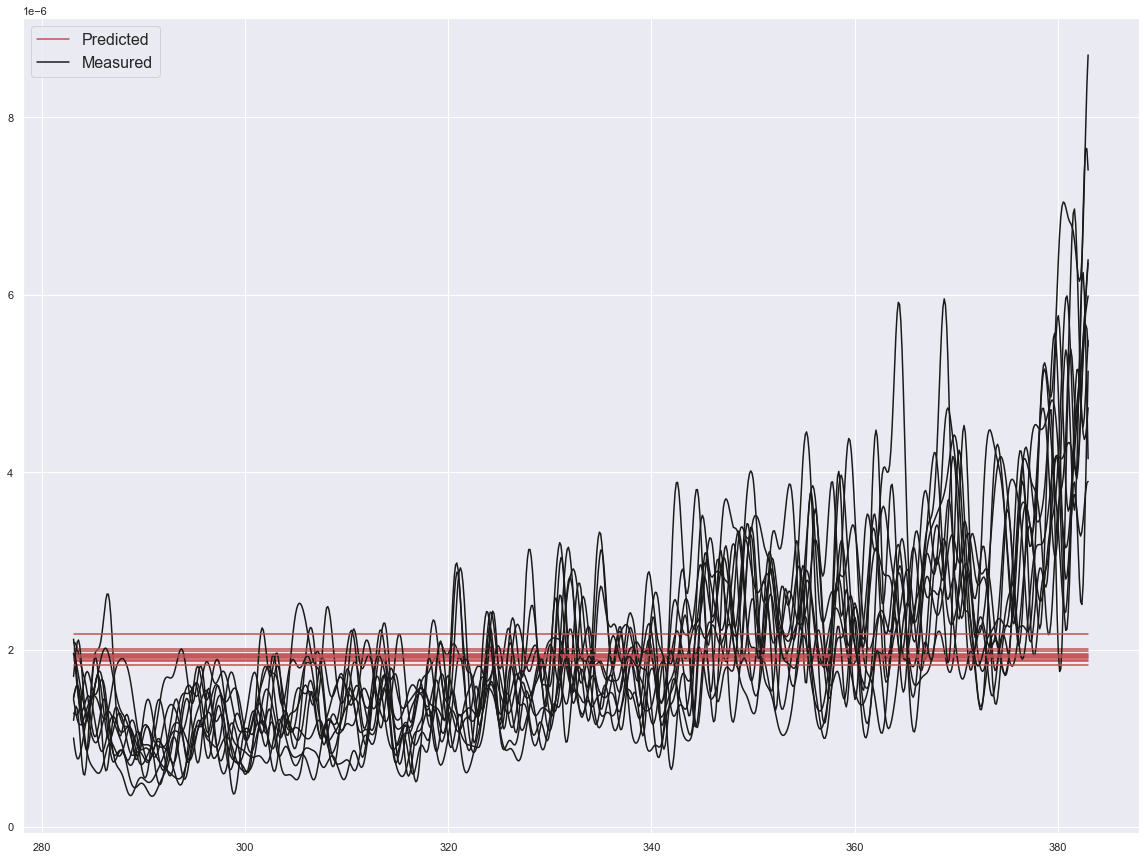

In [17]:
fig=plt.figure(figsize=(20, 15))
for ind in range(0, np.shape(sv)[1]):
    plt.plot(freqs,np.sum(sigbs*density_SGD[:,ind],1)+density_intercept[ind],'r', freqs ,arr.array('d',sv[:,ind]),'k')
plt.legend(['Predicted', 'Measured'], fontsize=16)


What does intercept represent?? Noise??
Either way **BAD prediction**

In [ ]:
reg.n_iter_


In [ ]:
np.shape(density)